In [1]:
import numpy as np
import sys
from collections import Counter
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
import math
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import contractions
import re
import spacy
from spacy import displacy
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import time
import keras
from keras.models import Model
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.optimizers import SGD

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pburn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pburn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pburn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
STOP_WORDS = set(stopwords.words('english'))
NER = spacy.load("en_core_web_sm")

In [3]:
# Reading in dataset
yelp_df = pd.read_csv("yelp.csv")
yelp_df = yelp_df[['review_id', 'text', 'stars']]
yelp_df['stars'] = yelp_df['stars'].apply(str)
yelp_df.head()

,review_id,text,stars
0,fWKvX83p0-ka4JS3dc6E5A,My wife took me here on my birthday for breakf...,5
1,IjZ33sJrzXqU-0X6U8NwyA,I have no idea why some people give bad review...,5
2,IESLBzqUCLdSzSqm0eCSxQ,love the gyro plate. Rice is so good and I als...,4
3,G-WvGaISbqqaMHlNnByodA,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,1uJFq2r5QfJG_6ExMRCaGw,General Manager Scott Petello is a good egg!!!...,5


In [4]:
# Reading in dataset
movie_df = pd.read_csv("movie.csv")
movie_df.head()
movie_df = movie_df[['text', 'label']]
# yelp_df['stars'] = yelp_df['stars'].apply(str)
movie_df.head()


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
def apply_space_tokenization(text):
    new_text = text.split(' ')
    return new_text

def apply_lowercase(text):
    new_text = text.lower()
    return new_text

In [6]:
yelp_df['text'] = yelp_df['text'].apply(apply_lowercase)
#yelp_df['text'] = yelp_df['text'].apply(apply_space_tokenization)
yelp_df

,review_id,text,stars
0,fWKvX83p0-ka4JS3dc6E5A,my wife took me here on my birthday for breakf...,5
1,IjZ33sJrzXqU-0X6U8NwyA,i have no idea why some people give bad review...,5
2,IESLBzqUCLdSzSqm0eCSxQ,love the gyro plate. rice is so good and i als...,4
3,G-WvGaISbqqaMHlNnByodA,"rosie, dakota, and i love chaparral dog park!!...",5
4,1uJFq2r5QfJG_6ExMRCaGw,general manager scott petello is a good egg!!!...,5
...,...,...,...
9995,Ubyfp2RSDYW0g7Mbr8N3iA,first visit...had lunch here today - used my g...,3
9996,2XyIOQKbVFb6uXQdJ0RzlQ,should be called house of deliciousness!\n\ni ...,4
9997,jyznYkIbpqVmlsZxSDSypA,i recently visited olive and ivy for business ...,4
9998,5UKq9WQE1qQbJ0DJbc-B6Q,my nephew just moved to scottsdale recently so...,2


In [7]:
movie_df['text'] = movie_df['text'].apply(apply_lowercase)
#yelp_df['text'] = yelp_df['text'].apply(apply_space_tokenization)
movie_df = movie_df[0:1000]
movie_df

,text,label
0,i grew up (b. 1965) watching and loving the th...,0
1,"when i put this movie in my dvd player, and sa...",0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1
...,...,...
995,"oh, this is so bad, it is funny. the only way ...",0
996,i couldn't believe this terrible movie was act...,0
997,even though i am slightly older than the recom...,1
998,reading web sites on bette davis one can find ...,1


# Preprocessing Expirements
#### Potentially we do some constants throughout our experiments? I.e Tokenize just by spaces, and lowecase all

### No Pre-Processing

### Lemanization

In [8]:
def apply_lem(text):
    lem = WordNetLemmatizer()
    new_text = []
    for word in text.split(' '):
        new_word = lem.lemmatize(word)
        new_text.append(new_word)
    review = ' '.join(new_text)
    return review

### Stemming

In [9]:
def apply_stemming(text):
    ps = PorterStemmer()
    new_text = []
    for word in text.split(' '):
        new_word = ps.stem(word)
        new_text.append(new_word)
    review = ' '.join(new_text)
    return review

### Contraction expansion

In [10]:
def apply_contraction_expansion(text):
    new_text = []
    for word in text.split(' '):
        new_word = contractions.fix(text)
        new_text.append(new_word)
    review = ' '.join(new_text)
    return review

### Removing Number related text

In [11]:
def apply_number_removal(text):
    review = re.sub(r'[0-9]', '', text)
    return review

### Punctuation Removal

In [12]:
def apply_punctuation_removal(text):
    review = re.sub(r'[.,!?-_;:&#$@%=+]', '', text)
    return review

### Stopword Removal

In [13]:
def apply_stopword_removal(text):
    new_text = []
    for word in text.split(' '):
        if text in STOP_WORDS:
            continue
        else:
            new_text.append(word)
    review = ' '.join(new_text)
    return review

### Spell Check Removal

In [14]:
def apply_spelling_correction(text):
    textBlb = TextBlob(text)
    textCorrected = textBlb.correct() 
    return textCorrected

### NER AND POS TAGGING

In [15]:
def apply_spacy(text):
    applied_text = NER(text)
    return applied_text.text


def get_pos(spacy_text):
    new_sentence = []
    excluded_tags = {"NOUN", "PRON", "PROPN", "DET", "ADP", "PUNCT",}
    for word in spacy_text:
        if word.pos_ not in excluded_tags:
            new_sentence.append(word.text)
    review = ' '.join(new_sentence)
    return review

# def get_ner(spacy_text):
#     for word in spacy_text:
        
#         print(word.text, word.label_)
        
# to return the labels
# spacy_words = apply_spacy("I honestly hated the play, it was so boring")   
# get_pos(spacy_words)

# for word in spacy_words.ents:
#     print(word.text,word.label_)




### Removing Certain P.O.S

### Pre-Processing Combination
#### Perhaps we run experiments with random combinations of all methods and see best performance

# Model Creation & Test Execution

In [16]:
def report_metrics(gold_labels, predicted_labels, name, clf):
    labels = [0, 1]
    # Reporting metrics & confusion matrix
    acc = round(accuracy_score(gold_labels, predicted_labels), 4)
    err = round(1 - acc, 4)
    pre = round(precision_score(gold_labels, predicted_labels), 4)
    rec = round(recall_score(gold_labels, predicted_labels), 4)
    f1 = round(f1_score(gold_labels, predicted_labels), 4)

    print("Accuracy: ", acc)
    print("Error: ", err)
    print("Precision: ", pre)
    print("Recall: ", rec)
    print("F1-Score: ", f1)

    cf_matrix = confusion_matrix(gold_labels, predicted_labels, labels=labels)
    rcParams['figure.figsize'] = (6, 4)
    sns.heatmap(cf_matrix, annot=True, cmap="Greens", xticklabels=labels, yticklabels=labels, fmt='g')
    plt.title(name)
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    
    return acc, err, pre, rec, f1

In [17]:
def setup_experiment(text, labels, pre_processing_step):
    # Creating a corpus (list of documents)
    start_time = time.time()
    corpus = list((map(pre_processing_step, text)))
    end_time = time.time()
    print(end_time-start_time)
    
    # Using BOW representation
    vectorizer = CountVectorizer(max_features=500)
    
    X = vectorizer.fit_transform(corpus).toarray()
    y = labels
    
    return X, y, end_time - start_time

In [18]:
def run_experiment(X, y, model_name, time):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
    
    if model_name == 'NB':
        model = MultinomialNB()
        # Running experiment
        model.fit(X_train, y_train)
    
        # Make predictions
        predictions = model.predict(X_test)
        
        # Calculating metrics
        acc, err, pre, rec, f1 = report_metrics(y_test, predictions, model_name, model)
        
        return acc, err, pre, rec, f1, time
    
    elif model_name == 'Deep':
        model = keras.Sequential([
        layers.Dense(400, activation="relu"),
        layers.Dense(400, activation="relu"),
        layers.Dense(200, activation="relu"),
        layers.Dense(1, activation="sigmoid")])
        model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
        
        # Running experiment
        model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)
        
        # Make predictions
        predictions = model.predict_classes(X_test)
        
        # Calculating metrics
        acc, err, pre, rec, f1 = report_metrics(y_test, predictions, model_name, model)
        
        return acc, err, pre, rec, f1, time
    else:
        pass

lem
1.2247662544250488
Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7013 - accuracy: 0.5525
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6115 - accuracy: 0.6538
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5751 - accuracy: 0.7075
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5112 - accuracy: 0.7525
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4627 - accuracy: 0.7812
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4432 - accuracy: 0.7950
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.8037
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3502 - accuracy: 0.8700
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8950
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.8850
Accuracy:  0.665

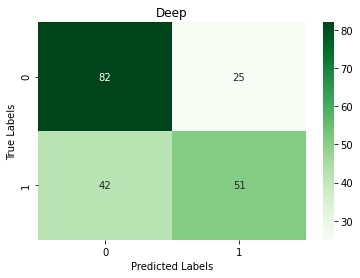

stemming
5.304919242858887
Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5512
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6261 - accuracy: 0.6612
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5715 - accuracy: 0.6975
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5218 - accuracy: 0.7437
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4648 - accuracy: 0.7975
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.7588
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6322 - accuracy: 0.7075
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5313 - accuracy: 0.7462
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4443 - accuracy: 0.8288
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3760 - accuracy: 0.8500
Accuracy:  0

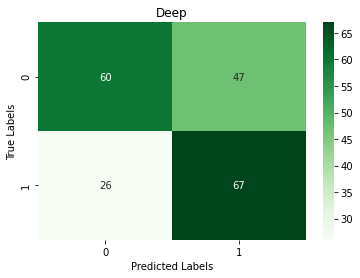

contraction_expansion
41.38848376274109
Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4725 
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.5188
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.5188
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5188
Accuracy:  0.535
Error:  0.4

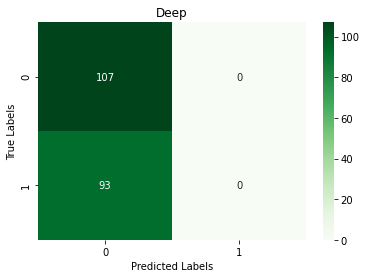

number_removal
0.01296377182006836
Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7197 - accuracy: 0.5437
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6301 - accuracy: 0.6438
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.6913
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5615 - accuracy: 0.7300
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5039 - accuracy: 0.7887
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4505 - accuracy: 0.8087
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.8075
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3789 - accuracy: 0.8425
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3558 - accuracy: 0.8562
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3997 - accuracy: 0.8313
Accu

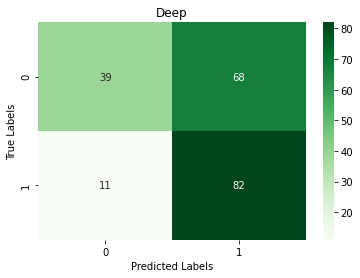

punctuation_removal
0.01748967170715332
Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5612
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.6275
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6491 - accuracy: 0.6325
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6431 - accuracy: 0.6475
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6060 - accuracy: 0.6825
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5816 - accuracy: 0.6925
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.7450
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5095 - accuracy: 0.7538
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4666 - accuracy: 0.7987
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.8200

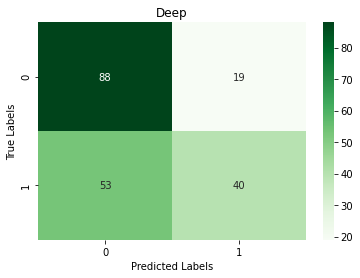

stopword_removal
0.05186152458190918
Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7043 - accuracy: 0.5150
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6780 - accuracy: 0.5763
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6290 - accuracy: 0.6438
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5926 - accuracy: 0.6775
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5399 - accuracy: 0.7663
Epoch 6/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7775
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4855 - accuracy: 0.7925
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4707 - accuracy: 0.8000
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4550 - accuracy: 0.8163
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4058 - accuracy: 0.8288
Ac

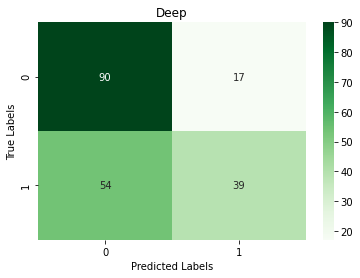

pos_removal
40.30932641029358
Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.8313 - accuracy: 0.5025
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5500
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6642 - accuracy: 0.6087
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.6625
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5753 - accuracy: 0.7387
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5346 - accuracy: 0.7613
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.5053 - accuracy: 0.7688
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4782 - accuracy: 0.7850
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.8238
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.3996 - accuracy: 0.8425
Accuracy:

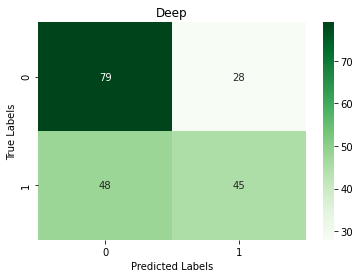

lem
1.1238164901733398
Accuracy:  0.73
Error:  0.27
Precision:  0.7294
Recall:  0.6667
F1-Score:  0.6966


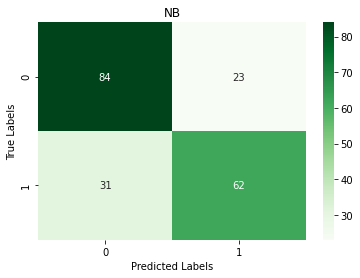

stemming
5.113436460494995
Accuracy:  0.705
Error:  0.295
Precision:  0.6932
Recall:  0.6559
F1-Score:  0.674


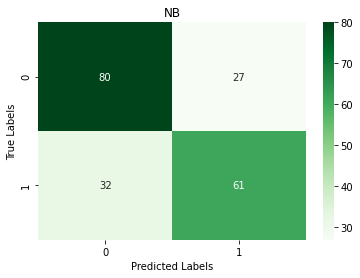

contraction_expansion
40.09238624572754
Accuracy:  0.705
Error:  0.295
Precision:  0.7429
Recall:  0.5591
F1-Score:  0.638


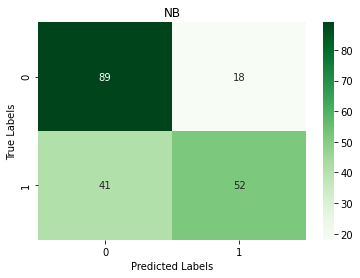

number_removal
0.013962507247924805
Accuracy:  0.72
Error:  0.28
Precision:  0.7229
Recall:  0.6452
F1-Score:  0.6818


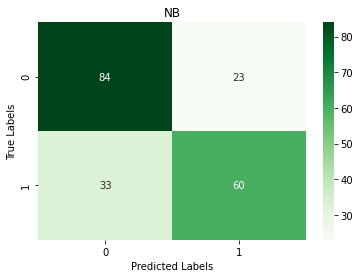

punctuation_removal
0.014960050582885742
Accuracy:  0.72
Error:  0.28
Precision:  0.7229
Recall:  0.6452
F1-Score:  0.6818


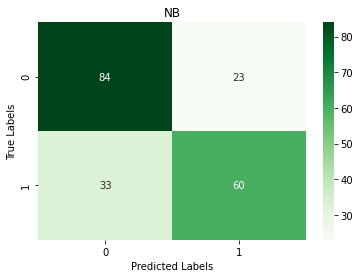

stopword_removal
0.043883323669433594
Accuracy:  0.72
Error:  0.28
Precision:  0.7229
Recall:  0.6452
F1-Score:  0.6818


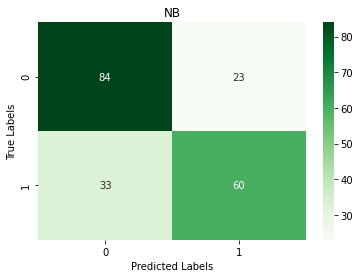

pos_removal
39.71013259887695
Accuracy:  0.72
Error:  0.28
Precision:  0.7229
Recall:  0.6452
F1-Score:  0.6818


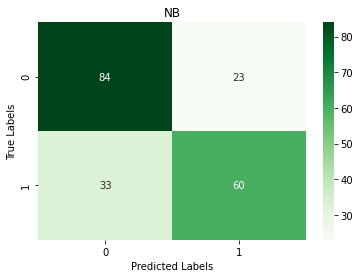

In [20]:
# Pre-processing options
# apply_spelling_correction
options = [apply_lem, apply_stemming, apply_contraction_expansion, apply_number_removal,
          apply_punctuation_removal, apply_stopword_removal, apply_spacy]
options_string = ['lem', 'stemming', 'contraction_expansion', 'number_removal',
          'punctuation_removal', 'stopword_removal', 'pos_removal']

columns = ['Pre-Processing', 'Acuracy', 'Error', 'Precision', 'Recall', 'F1-Score', 'Time']

results_df = pd.DataFrame(columns=columns)

text = movie_df['text'].to_numpy()
labels = movie_df['label'].to_numpy()

# Running experiments for Neural Network model
for option, name in zip(options, options_string):
    print(name)
    X, y, t = setup_experiment(text, labels, option)
    acc, err, pre, rec, f1, t  = run_experiment(X, y, "Deep", t)
    df_dict = {'Pre-Processing':"Deep-"+name, 'Acuracy':acc, 'Error':err, 'Precision':pre, 
               'Recall':rec, 'F1-Score':f1, 'Time':t}
    results_df = results_df.append(df_dict, ignore_index=True)
    
# Running experiments for Naive Bayes model
for option, name in zip(options, options_string):
    print(name)
    X, y, t = setup_experiment(text, labels, option)
    acc, err, pre, rec, f1, t  = run_experiment(X, y, "NB", t)
    df_dict = {'Pre-Processing':"NB-"+name, 'Acuracy':acc, 'Error':err, 'Precision':pre, 
               'Recall':rec, 'F1-Score':f1, 'Time':t}
    results_df = results_df.append(df_dict, ignore_index=True)

In [21]:
results_df

,Pre-Processing,Acuracy,Error,Precision,Recall,F1-Score,Time
0,Deep-lem,0.665,0.335,0.6711,0.5484,0.6036,1.224766
1,Deep-stemming,0.635,0.365,0.5877,0.7204,0.6473,5.304919
2,Deep-contraction_expansion,0.535,0.465,0.0000,0.0000,0.0000,41.388484
3,Deep-number_removal,0.605,0.395,0.5467,0.8817,0.6749,0.012964
4,Deep-punctuation_removal,0.640,0.360,0.6780,0.4301,0.5263,0.017490
5,Deep-stopword_removal,0.645,0.355,0.6964,0.4194,0.5235,0.051862
6,Deep-pos_removal,0.620,0.380,0.6164,0.4839,0.5422,40.309326
7,NB-lem,0.730,0.270,0.7294,0.6667,0.6966,1.123816
8,NB-stemming,0.705,0.295,0.6932,0.6559,0.6740,5.113436
9,NB-contraction_expansion,0.705,0.295,0.7429,0.5591,0.6380,40.092386


# Result Collection & Visualization